# Backdoor v2: Using `Re78` - `Re75`

Using linear regression to model using a backdoor estimator on `Re78` - `Re75` before and after job training.

In [ ]:
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


def backdoor_param_a(df, treatment_col, outcome_col, confounder_cols):
    """
    Estimate the causal effect of the treatment on the outcome using the backdoor adjustment method.

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment, outcome, and confounder columns.
    - treatment_col (str): The name of the treatment column.
    - outcome_col (str): The name of the outcome column.
    - confounder_cols (list of str): A list of names of confounder columns.

    Returns:
    - param_a (float): The estimated causal effect of the treatment on the outcome.
    """
    formula = f"{outcome_col} ~ {treatment_col} + " + " + ".join(confounder_cols)
    model = smf.ols(formula=formula, data=df).fit()
    param_a = model.params[treatment_col]

    return param_a


def mean_diff_estimator(df, treatment_col, outcome_col):
    """
    Estimate the causal effect of the treatment on the outcome using the mean difference estimator.

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment and outcome columns.
    - treatment_col (str): The name of the treatment column.
    - outcome_col (str): The name of the outcome column.

    Returns:
    - effect (float): The estimated causal effect of the treatment on the outcome.
    """
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    effect = treated[outcome_col].mean() - control[outcome_col].mean()
    return effect


def backdoor_lr(df, treatment_col, outcome_col, confounder_cols):
    """
    Estimate the causal effect of the treatment on the outcome using a linear regression model
    for each treatment level and then averaging the predictions.

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment, outcome, and confounder columns.
    - treatment_col (str): The name of the treatment column.
    - outcome_col (str): The name of the outcome column.
    - confounder_cols (list of str): A list of names of confounder columns.

    Returns:
    - effect (float): The estimated causal effect of the treatment on the outcome.
    """
    results = []
    treatments = sorted(np.unique(df[treatment_col]))

    for a_val in treatments:
        df_a = df.loc[df[treatment_col] == a_val, :].reset_index(drop=True)
        formula = f"{outcome_col} ~ " + " + ".join(confounder_cols)
        model = smf.ols(formula=formula, data=df_a).fit()
        y_pred = model.predict(df)
        results.append(np.mean(y_pred))

    return results[1] - results[0]


def backdoor_classifier(
    df, treatment_col, outcome_col, confounder_cols, classifier_name="DecisionTree"
):
    """
    Estimate the causal effect of the treatment on the outcome using a specified classifier.

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment, outcome, and confounder columns.
    - treatment_col (str): The name of the treatment column.
    - outcome_col (str): The name of the outcome column.
    - confounder_cols (list of str): A list of names of confounder columns.
    - classifier_name (str): The name of the classifier to use ('DecisionTree' or 'LogisticRegression').

    Returns:
    - effect (float): The estimated causal effect of the treatment on the outcome.
    """
    classifiers = {
        "DecisionTree": DecisionTreeClassifier,
        "LogisticRegression": LogisticRegression,
    }

    if classifier_name not in classifiers:
        raise ValueError(
            f"Classifier '{classifier_name}' is not supported. Choose from {list(classifiers.keys())}"
        )

    classifier = classifiers[classifier_name]()

    results = []
    treatments = sorted(np.unique(df[treatment_col]))

    for a_val in treatments:
        df_a = df.loc[df[treatment_col] == a_val, :].reset_index(drop=True)

        X = df_a[confounder_cols]
        y = df_a[outcome_col]

        model = classifier.fit(X, y)

        X_full = df[confounder_cols]
        y_pred_prob = model.predict_proba(X_full)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)

        results.append(np.mean(y_pred))

    return results[1] / results[0]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
lalonde_exp = pd.read_csv("synthetic_exp.csv")
lalonde_obs = pd.read_csv("synthetic_observed.csv")

In [ ]:
lalonde_exp["re78_re75"] = lalonde_exp["re78"] - lalonde_exp["re75"]
lalonde_obs["re78_re75"] = lalonde_obs["re78"] - lalonde_obs["re75"]

Our average treatment effect is now a difference of differences

$\beta = E[Y^a - Y^{a'}] = E[(Re_{78} - Re_{75})^{a} - (Re_{78} - Re_{75})^{a'}]$

* We suspect that those with a higher initial income benefit less from job training, but have higher earnings in 1978.
* This is because those who start with higher salaries are likely to earn more in the future.
* Higher salary earners are also less likely to go for job training and also less likely to benefit from it.
* To look at this, let's see the distribution of incomes in our observational data.

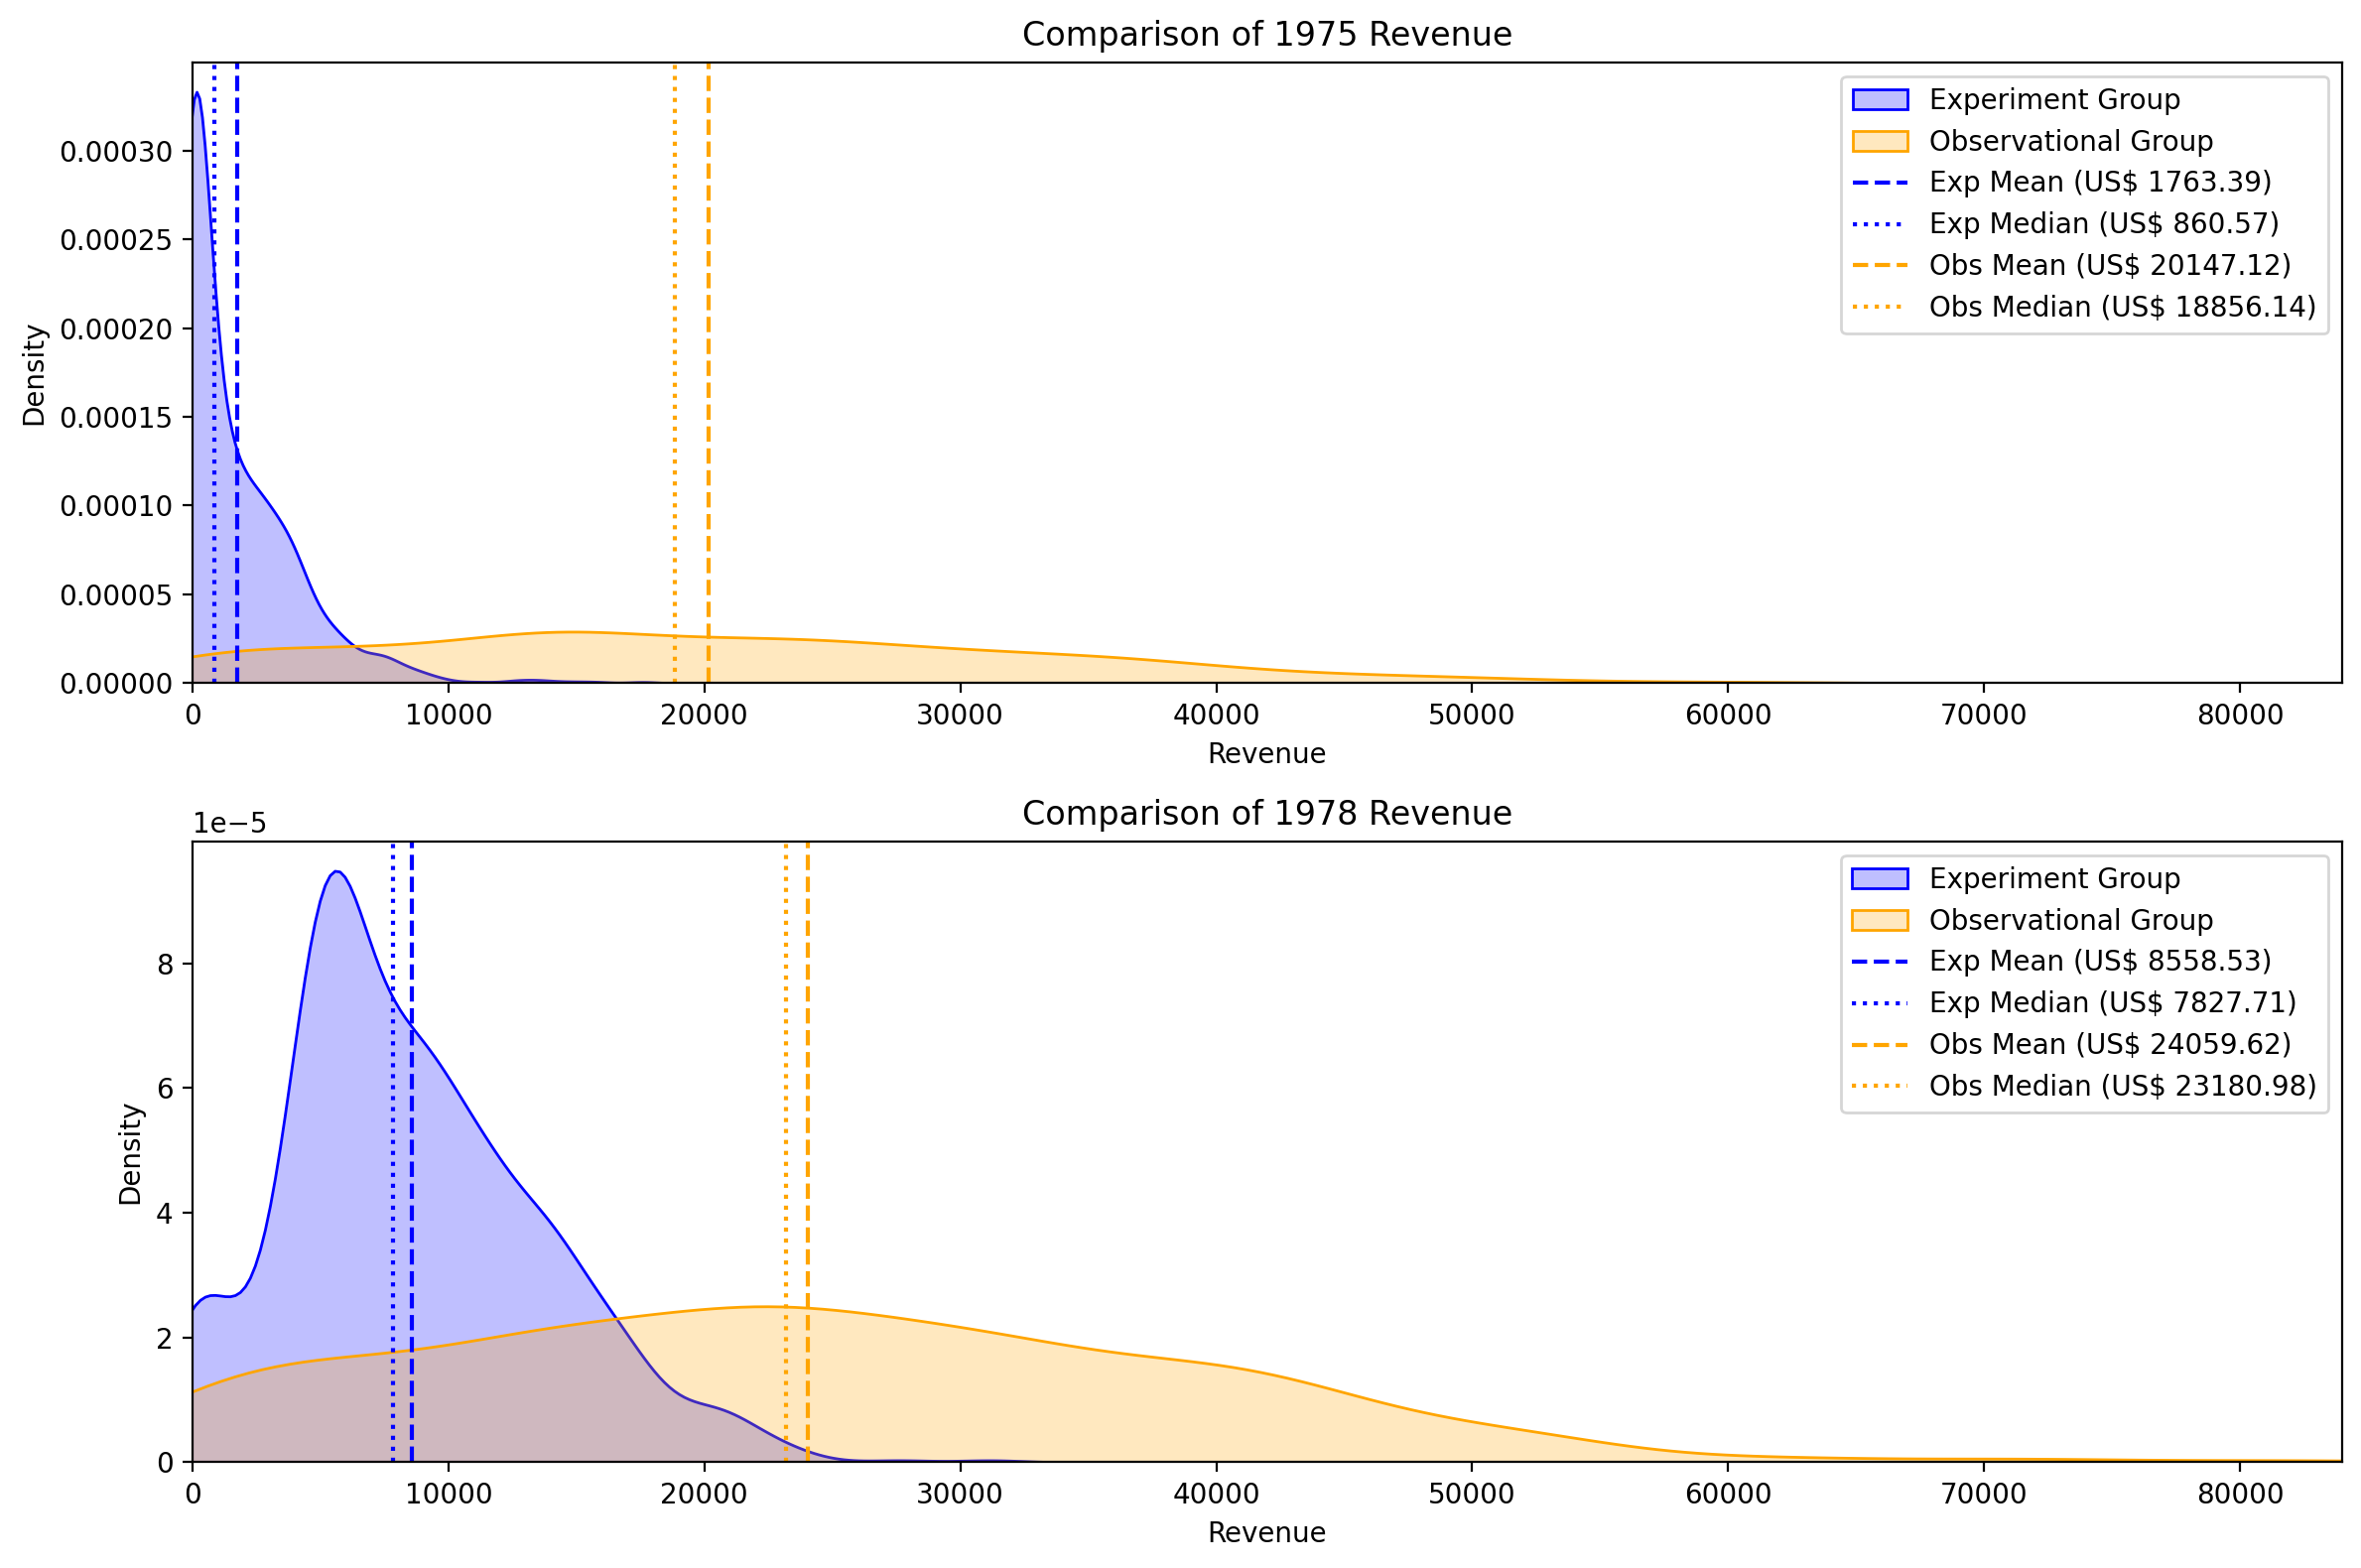

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=200)

columns = ["re75", "re78"]
titles = ["1975 Revenue", "1978 Revenue"]

global_min = min(lalonde_exp[columns].min().min(), lalonde_obs[columns].min().min())
global_max = max(lalonde_exp[columns].max().max(), lalonde_obs[columns].max().max())

for i, column in enumerate(columns):
    sns.kdeplot(
        lalonde_exp[column],
        ax=axes[i],
        color="blue",
        label="Experiment Group",
        fill=True,
    )
    sns.kdeplot(
        lalonde_obs[column],
        ax=axes[i],
        color="orange",
        label="Observational Group",
        fill=True,
    )

    exp_mean = lalonde_exp[column].mean()
    exp_median = lalonde_exp[column].median()
    obs_mean = lalonde_obs[column].mean()
    obs_median = lalonde_obs[column].median()

    axes[i].axvline(
        exp_mean, color="blue", linestyle="--", label=f"Exp Mean (US$ {exp_mean:.2f})"
    )
    axes[i].axvline(
        exp_median,
        color="blue",
        linestyle=":",
        label=f"Exp Median (US$ {exp_median:.2f})",
    )

    axes[i].axvline(
        obs_mean, color="orange", linestyle="--", label=f"Obs Mean (US$ {obs_mean:.2f})"
    )
    axes[i].axvline(
        obs_median,
        color="orange",
        linestyle=":",
        label=f"Obs Median (US$ {obs_median:.2f})",
    )

    axes[i].set_title(f"Comparison of {titles[i]}")
    axes[i].set_xlabel("Revenue")
    axes[i].set_ylabel("Density")
    axes[i].set_xlim(global_min, global_max)
    axes[i].legend()

plt.tight_layout()
plt.show()

* The above graph shows us that those in the observational group are at typically higher

## Backdoor Estimate

### Experimental Data

In [ ]:
import numpy as np
from tqdm import tqdm


def bootstrap(df, function, n=50, ci=95, set_seed=True, **kwargs):
    """
    Perform bootstrap resampling to estimate the confidence interval of a statistic.

    Parameters:
    - df (pd.DataFrame): The dataset to resample from.
    - function (callable): The function to apply to each resampled dataset. It should take the DataFrame
                           as its first argument and any additional keyword arguments.
    - n (int): The number of bootstrap samples to draw. Default is 50.
    - ci (int): The desired confidence interval percentage. Default is 95.
    - set_seed (bool): Whether to set a random seed for reproducibility. Default is True.
    - **kwargs: Additional keyword arguments to pass to the function.

    Returns:
    - numpy.ndarray: An array containing the mean, lower confidence interval, and upper confidence interval.
    """
    if set_seed:
        np.random.seed(42)
    results = []

    for _ in range(n):
        # this will ensure our bootstrapped sample is the same length
        # with replacement: https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
        new_df = df.sample(n=df.shape[0], replace=True)
        assert new_df.shape == df.shape  # same shape
        results.append(function(new_df, **kwargs))

    # CI calculations: https://statisticsbyjim.com/hypothesis-testing/bootstrapping/
    # E.g. 95% CI is 2.5% - 97.5%
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile

    results_arr = np.array(results)
    lower_ci = np.percentile(results_arr, lower_percentile, axis=0)
    upper_ci = np.percentile(results_arr, upper_percentile, axis=0)
    mean_ = np.mean(results_arr)

    return np.array([mean_, lower_ci, upper_ci])


def bootstrap_experiment(df, function, num_exp=10, n=50, ci=95, **kwargs):
    """
    Conduct multiple bootstrap experiments to estimate the variability of the bootstrap estimates.

    Parameters:
    - df (pd.DataFrame): The dataset to resample from.
    - function (callable): The function to apply to each resampled dataset. It should take the DataFrame
                           as its first argument and any additional keyword arguments.
    - num_exp (int): The number of bootstrap experiments to run. Default is 10.
    - n (int): The number of bootstrap samples to draw in each experiment. Default is 50.
    - ci (int): The desired confidence interval percentage. Default is 95.
    - **kwargs: Additional keyword arguments to pass to the function.

    Returns:
    - numpy.ndarray: An array containing the bootstrap results for each experiment.
    """
    experiment_results = []

    for _ in tqdm(range(num_exp), desc=f"Running experiments"):
        ci_result = bootstrap(df, function, n=n, ci=ci, set_seed=False, **kwargs)
        experiment_results.append(ci_result)

    return np.array(experiment_results)


In [ ]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_lr,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████| 50/50 [02:47<00:00,  3.35s/it]


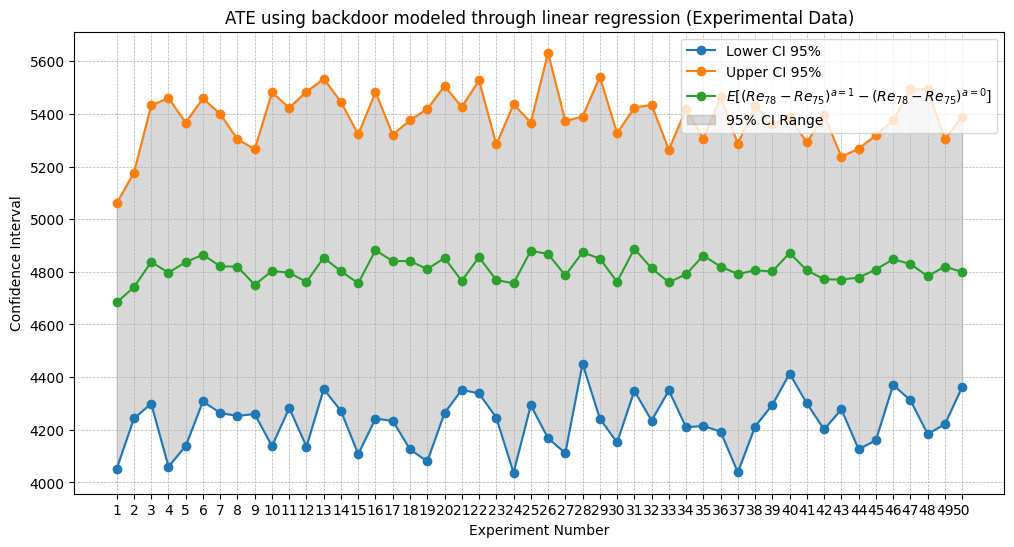

In [ ]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["experiment"],
    ci_df["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1} - (Re_{78} - Re_{75})^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Experimental Data)")
plt.legend()
plt.show()

In [ ]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
7,4819.815703,4252.652747,5303.936618,8
20,4765.783082,4351.939722,5426.300662,21
32,4760.344506,4349.313933,5264.045799,33
31,4813.915292,4235.082092,5434.384274,32
44,4808.765428,4160.336577,5318.653942,45
28,4850.539221,4242.673439,5540.858494,29
19,4852.430514,4263.752106,5505.808276,20
12,4854.129381,4354.720067,5533.422804,13
34,4861.999328,4214.686203,5305.745975,35
18,4810.387371,4080.187579,5418.513055,19


### Observational Data

In [ ]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_lr,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████| 50/50 [02:19<00:00,  2.78s/it]


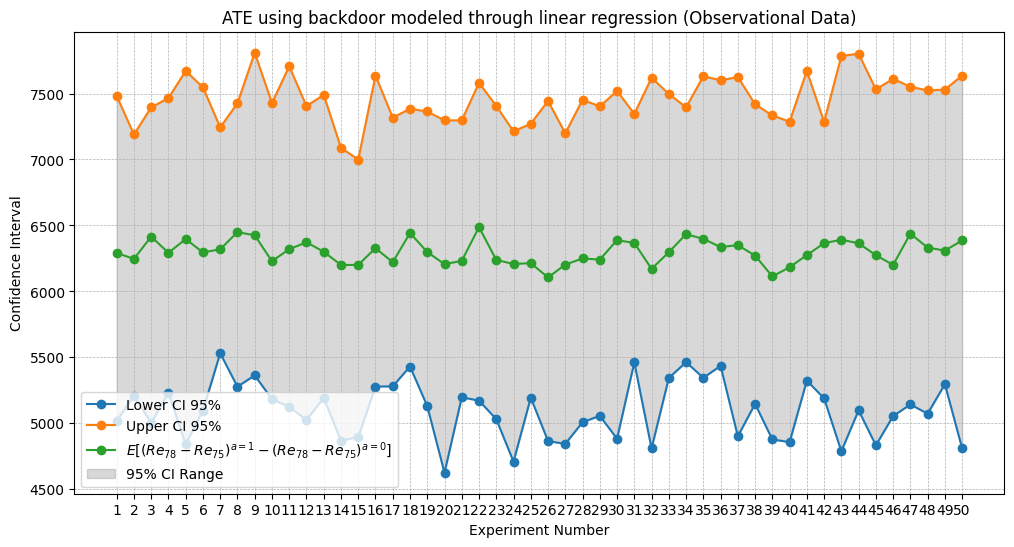

In [ ]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["experiment"],
    ci_df["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1} - (Re_{78} - Re_{75})^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Observational Data)")
plt.legend()
plt.show()

In [ ]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
13,6200.276393,4867.851128,7088.203142,14
38,6113.358890,4878.021802,7333.289391,39
35,6336.196662,5435.573943,7600.206712,36
29,6388.598329,4883.207467,7519.775934,30
3,6292.449416,5232.179125,7465.388628,4
15,6327.769440,5278.500121,7636.137164,16
39,6182.960694,4857.543147,7286.653838,40
27,6249.843505,5008.676412,7452.496012,28
19,6206.374162,4625.611606,7296.282634,20
37,6271.286172,5147.305594,7418.550951,38


But this estimate doesn't seem plausible with the observational data.

## Using a's parameter

### Experimental Data

In [ ]:
backdoor_result = backdoor_param_a(
    lalonde_exp,
    "treat",
    "re78_re75",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 4885.87.


In [ ]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_param_a,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


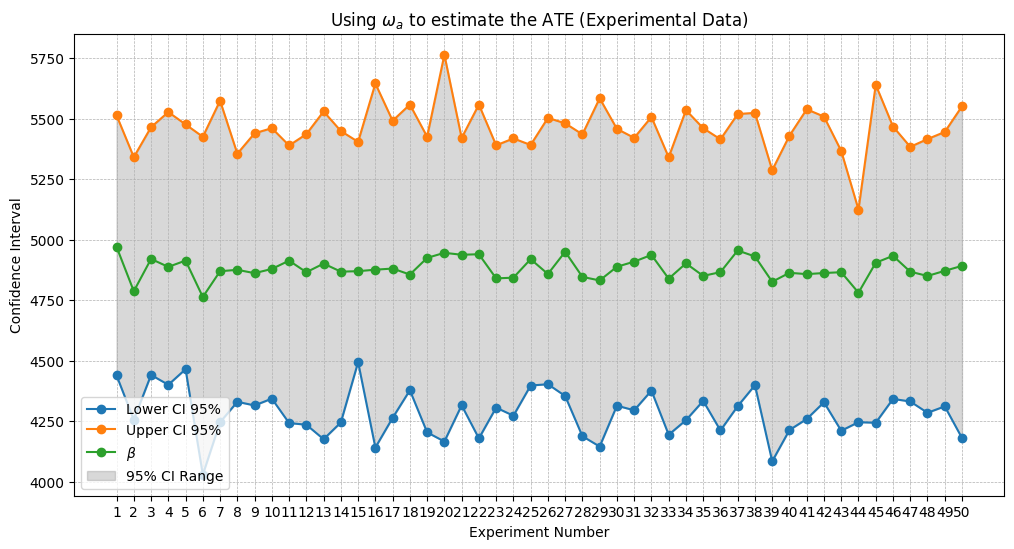

In [ ]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$\\beta$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using $\\omega_{a}$ to estimate the ATE (Experimental Data)")
plt.legend()
plt.show()

In [ ]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
3,4887.685486,4400.262912,5527.782405,4
19,4945.851351,4165.714935,5764.862462,20
36,4955.508393,4311.906841,5519.615143,37
13,4868.053895,4244.527021,5449.374011,14
14,4869.920395,4493.994449,5404.667824,15
5,4763.282983,4028.462764,5425.582765,6
9,4879.226289,4342.996203,5461.244515,10
46,4867.839863,4331.306571,5384.067237,47
17,4856.069790,4377.647214,5558.885456,18
6,4869.805763,4245.356721,5574.906539,7


### Using Observational data

In [ ]:
backdoor_result = backdoor_param_a(
    lalonde_obs,
    "treat",
    "re78_re75",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 6268.32.


In [ ]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_param_a,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


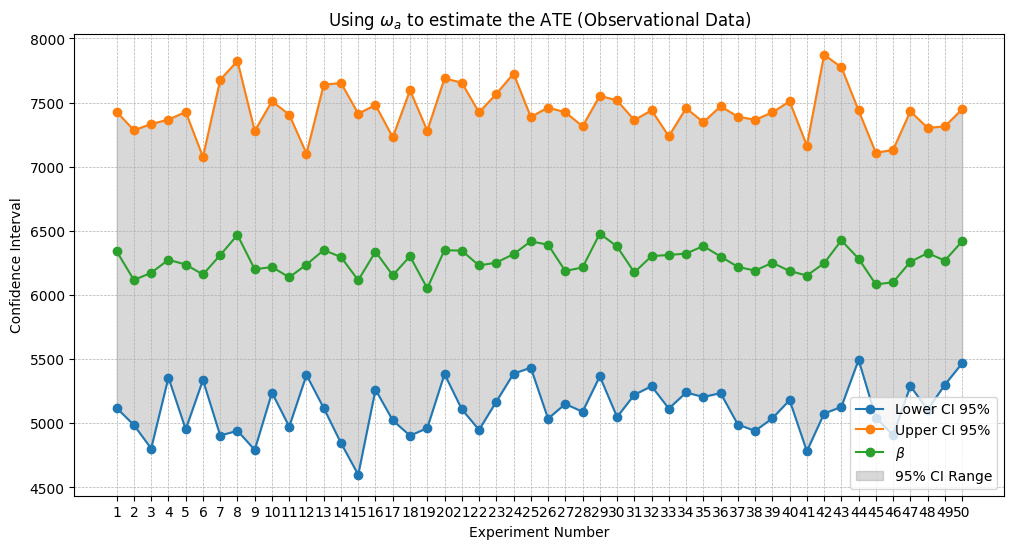

In [ ]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$\\beta$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using $\\omega_{a}$ to estimate the ATE (Observational Data)")
plt.legend()
plt.show()

In [ ]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
31,6303.218108,5289.288062,7440.461381,32
42,6425.618500,5127.458563,7775.905806,43
39,6187.292678,5180.555007,7510.179054,40
18,6052.159186,4962.472568,7281.148213,19
30,6176.135782,5221.814412,7363.372630,31
36,6219.413919,4990.239556,7390.257042,37
22,6252.477966,5168.310470,7567.865398,23
3,6274.640519,5356.651561,7367.585550,4
1,6116.889753,4985.983086,7284.834637,2
11,6237.266064,5376.334793,7102.849690,12


* We might be overfitting with the backdoor estimator
* The outcome is linearly dependent on A

### Bootstrap

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Function Definitions

def backdoor_param_a(df, treatment_col, outcome_col, confounder_cols):
    formula = f"{outcome_col} ~ {treatment_col} + " + " + ".join(confounder_cols)
    model = smf.ols(formula=formula, data=df).fit()
    param_a = model.params[treatment_col]
    return param_a

def mean_diff_estimator(df, treatment_col, outcome_col):
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    effect = treated[outcome_col].mean() - control[outcome_col].mean()
    return effect

def backdoor_lr(df, treatment_col, outcome_col, confounder_cols):
    results = []
    treatments = sorted(np.unique(df[treatment_col]))

    for a_val in treatments:
        df_a = df.loc[df[treatment_col] == a_val, :].reset_index(drop=True)
        formula = f"{outcome_col} ~ " + " + ".join(confounder_cols)
        model = smf.ols(formula=formula, data=df_a).fit()
        y_pred = model.predict(df)
        results.append(np.mean(y_pred))

    return results[1] - results[0]

def backdoor_classifier(df, treatment_col, outcome_col, confounder_cols, classifier_name="DecisionTree"):
    classifiers = {
        "DecisionTree": DecisionTreeClassifier,
        "LogisticRegression": LogisticRegression,
    }

    if classifier_name not in classifiers:
        raise ValueError(
            f"Classifier '{classifier_name}' is not supported. Choose from {list(classifiers.keys())}"
        )

    classifier = classifiers[classifier_name]()
    results = []
    treatments = sorted(np.unique(df[treatment_col]))

    for a_val in treatments:
        df_a = df.loc[df[treatment_col] == a_val, :].reset_index(drop=True)
        X = df_a[confounder_cols]
        y = df_a[outcome_col]
        model = classifier.fit(X, y)
        X_full = df[confounder_cols]
        y_pred_prob = model.predict_proba(X_full)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)
        results.append(np.mean(y_pred))

    return results[1] / results[0]

# Bootstrap Functions

def bootstrap(df, function, n=1000, ci=95, **kwargs):
    np.random.seed(42)
    estimates = []
    for _ in range(n):
        sample = df.sample(frac=1, replace=True)
        est = function(sample, **kwargs)
        estimates.append(est)
    estimates = np.array(estimates)
    lower = np.percentile(estimates, (100 - ci) / 2, axis=0)
    upper = np.percentile(estimates, 100 - (100 - ci) / 2, axis=0)
    mean_estimate = np.mean(estimates, axis=0)
    return np.vstack([mean_estimate, lower, upper])

def bootstrap_experiment(df, function, num_exp=10, n=1000, ci=95, **kwargs):
    experiment_results = []

    for _ in tqdm(range(num_exp), desc=f"Running experiments"):
        ci_result = bootstrap(df, function, n=n, ci=ci, **kwargs)
        experiment_results.append(ci_result)

    return np.array(experiment_results)

# Data Loading and Processing

lalonde_exp = pd.read_csv("synthetic_exp.csv")
lalonde_obs = pd.read_csv("synthetic_observed.csv")

lalonde_exp["re78_re75"] = lalonde_exp["re78"] - lalonde_exp["re75"]
lalonde_obs["re78_re75"] = lalonde_obs["re78"] - lalonde_obs["re75"]

# Bootstrap Analysis for Experimental Data

backdoor_boostrap_results_exp = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_lr,
    num_exp=50,
    n=1000,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

ci_df_exp = pd.DataFrame(
    backdoor_boostrap_results_exp, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df_exp["experiment"] = range(1, len(ci_df_exp) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df_exp["experiment"], ci_df_exp["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df_exp["experiment"], ci_df_exp["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df_exp["experiment"],
    ci_df_exp["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1} - (Re_{78} - Re_{75})^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df_exp["experiment"],
    ci_df_exp["lower_ci"],
    ci_df_exp["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df_exp["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Experimental Data)")
plt.legend()
plt.show()

# Bootstrap Analysis for Observational Data

backdoor_boostrap_results_obs = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_lr,
    num_exp=50,
    n=1000,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

ci_df_obs = pd.DataFrame(
    backdoor_boostrap_results_obs, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df_obs["experiment"] = range(1, len(ci_df_obs) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df_obs["experiment"], ci_df_obs["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df_obs["experiment"], ci_df_obs["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df_obs["experiment"],
    ci_df_obs["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1} - (Re_{78} - Re_{75})^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df_obs["experiment"],
    ci_df_obs["lower_ci"],
    ci_df_obs["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df_obs["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Observational Data)")
plt.legend()
plt.show()

# Analysis using backdoor_param_a

backdoor_result_exp = backdoor_param_a(
    lalonde_exp,
    "treat",
    "re78_re75",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(f"The difference between the treatment and no-treatment groups in experimental data is {backdoor_result_exp:.2f}.")

backdoor_result_obs = backdoor_param_a(
    lalonde_obs,
    "treat",
    "re78_re75",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(f"The difference between the treatment and no-treatment groups in observational data is {backdoor_result_obs:.2f}.")

backdoor_boostrap_results_exp_param = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_param_a,
    num_exp=50,
    n=1000,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

ci_df_exp_param = pd.DataFrame(
    backdoor_boostrap_results_exp_param, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df_exp_param["experiment"] = range(1, len(ci_df_exp_param) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df_exp_param["experiment"], ci_df_exp_param["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df_exp_param["experiment"], ci_df_exp_param["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df_exp_param["experiment"], ci_df_exp_param["mean"], label="$\\beta$", marker="o")

plt.fill_between(
    ci_df_exp_param["experiment"],
    ci_df_exp_param["lower_ci"],
    ci_df_exp_param["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df_exp_param["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using $\\omega_{a}$ to estimate the ATE (Experimental Data)")
plt.legend()
plt.show()

backdoor_boostrap_results_obs_param = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_param_a,
    num_exp=50,
    n=1000,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

ci_df_obs_param = pd.DataFrame(
    backdoor_boostrap_results_obs_param, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df_obs_param["experiment"] = range(1, len(ci_df_obs_param) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df_obs_param["experiment"], ci_df_obs_param["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df_obs_param["experiment"], ci_df_obs_param["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df_obs_param["experiment"], ci_df_obs_param["mean"], label="$\\beta$", marker="o")

plt.fill_between(
    ci_df_obs_param["experiment"],
    ci_df_obs_param["lower_ci"],
    ci_df_obs_param["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df_obs_param["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using $\\omega_{a}$ to estimate the ATE (Observational Data)")
plt.legend()
plt.show()

ci_df_obs_param.sample(10)


Running experiments: 100%|██████████| 50/50 [48:23<00:00, 58.08s/it]


ValueError: Must pass 2-d input. shape=(50, 3, 1)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Function Definitions

def backdoor_param_a(df, treatment_col, outcome_col, confounder_cols):
    formula = f"{outcome_col} ~ {treatment_col} + " + " + ".join(confounder_cols)
    model = smf.ols(formula=formula, data=df).fit()
    param_a = model.params[treatment_col]
    return param_a

def backdoor_lr(df, treatment_col, outcome_col, confounder_cols):
    results = []
    treatments = sorted(np.unique(df[treatment_col]))

    for a_val in treatments:
        df_a = df.loc[df[treatment_col] == a_val, :].reset_index(drop=True)
        formula = f"{outcome_col} ~ " + " + ".join(confounder_cols)
        model = smf.ols(formula=formula, data=df_a).fit()
        y_pred = model.predict(df)
        results.append(np.mean(y_pred))

    return results[1] - results[0]

def bootstrap(df, function, n=50, ci=95, set_seed=True, **kwargs):
    if set_seed:
        np.random.seed(42)
    results = []

    for _ in range(n):
        new_df = df.sample(n=df.shape[0], replace=True)
        assert new_df.shape == df.shape
        results.append(function(new_df, **kwargs))

    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile

    results_arr = np.array(results)
    lower_ci = np.percentile(results_arr, lower_percentile, axis=0)
    upper_ci = np.percentile(results_arr, upper_percentile, axis=0)
    mean_ = np.mean(results_arr)

    return np.array([mean_, lower_ci, upper_ci])

def bootstrap_experiment(df, function, num_exp=10, n=50, ci=95, **kwargs):
    experiment_results = []

    for _ in tqdm(range(num_exp), desc=f"Running experiments"):
        ci_result = bootstrap(df, function, n=n, ci=ci, set_seed=False, **kwargs)
        experiment_results.append(ci_result)

    return np.array(experiment_results)

# Data Loading and Processing

lalonde_exp = pd.read_csv("synthetic_exp.csv")
lalonde_obs = pd.read_csv("synthetic_observed.csv")

lalonde_exp["re78_re75"] = lalonde_exp["re78"] - lalonde_exp["re75"]
lalonde_obs["re78_re75"] = lalonde_obs["re78"] - lalonde_obs["re75"]


Bootstrap Analysis for Experimental Data using backdoor_lr

In [ ]:
# Experimental Data using backdoor_lr
backdoor_boostrap_results_exp_lr = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_lr,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

ci_df_exp_lr = pd.DataFrame(
    backdoor_boostrap_results_exp_lr, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df_exp_lr["experiment"] = range(1, len(ci_df_exp_lr) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df_exp_lr["experiment"], ci_df_exp_lr["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df_exp_lr["experiment"], ci_df_exp_lr["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df_exp_lr["experiment"],
    ci_df_exp_lr["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1} - (Re_{78} - Re_{75})^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df_exp_lr["experiment"],
    ci_df_exp_lr["lower_ci"],
    ci_df_exp_lr["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df_exp_lr["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Experimental Data)")
plt.legend()
plt.show()


Bootstrap Analysis for Observational Data using backdoor_lr

In [ ]:
# Observational Data using backdoor_lr
backdoor_boostrap_results_obs_lr = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_lr,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

ci_df_obs_lr = pd.DataFrame(
    backdoor_boostrap_results_obs_lr, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df_obs_lr["experiment"] = range(1, len(ci_df_obs_lr) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df_obs_lr["experiment"], ci_df_obs_lr["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df_obs_lr["experiment"], ci_df_obs_lr["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df_obs_lr["experiment"],
    ci_df_obs_lr["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1} - (Re_{78} - Re_{75})^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df_obs_lr["experiment"],
    ci_df_obs_lr["lower_ci"],
    ci_df_obs_lr["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df_obs_lr["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Observational Data)")
plt.legend()
plt.show()


Analysis using backdoor_param_a for Experimental Data